# YouTube trending videos

In [38]:
import os

import numpy as np
from numpy import nan

nan
import pandas as pd
from matplotlib import pyplot as plt

from helpers.json_helper import load_tokenized_text
from helpers.files import load_csv, load_csv_file

numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day", "publish_time", "movie_domains_count"
]


## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych -> w jego
kontekscie można opisać dlaczego tak pobieramy

### Pomysł na pobranie danych nie trending

- Podział okresu 11.2017-07.2018 na 4 podokresy
- Zbieranie danych „proporcjami” wystąpień kategorii podobnymi do oryginalnych
- Filtrowanie filmów trending
- Filtrowanie ewentualnych powtórzeń
- Uzupełnianie statystyk

Testowe dane

### Wczytanie danych trending

In [39]:
gb_videos, us_videos = load_csv("ped3_data")
trending_videos = pd.concat([gb_videos, us_videos])

for name in numeric_attrs:
    trending_videos[name] = trending_videos[name].apply(lambda x: eval(x)[0] if eval(x) else np.nan)



### Wczytanie danych nie trending

In [40]:
gb_non_videos, us_non_videos = load_csv("ped5_full_data")
non_trending_videos = pd.concat([gb_non_videos, us_non_videos])
non_trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

### Atrybuty liczbowe

**Funkcja do rysowania wykresów**

In [41]:
def plot_numeric_attr(attr_name: str, trending: pd.DataFrame, non_trending: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    axes[0, 0].hist(trending[attr_name])
    axes[0, 0].title.set_text(f"Trending: {attr_name}")
    axes[0, 1].hist(non_trending[attr_name])
    axes[0, 1].title.set_text(f"Non Trending: {attr_name}")
    axes[1, 0].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"]
    )
    axes[1, 1].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"],
        showfliers=False
    )

**Views**

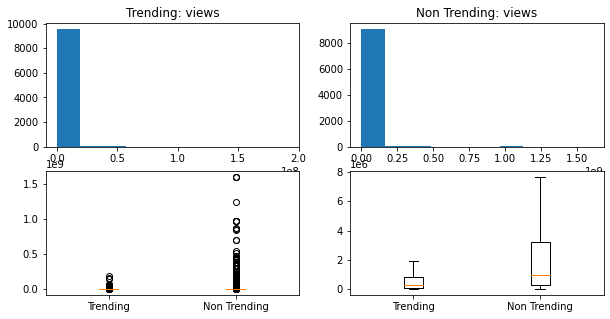

In [42]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

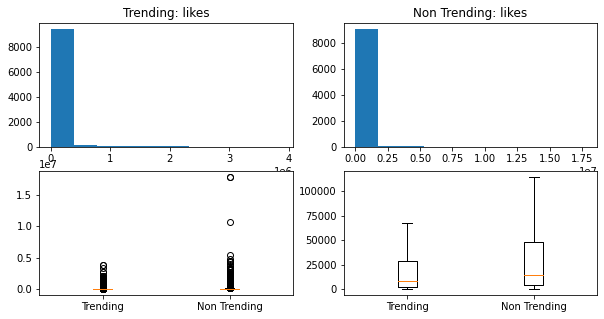

In [43]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

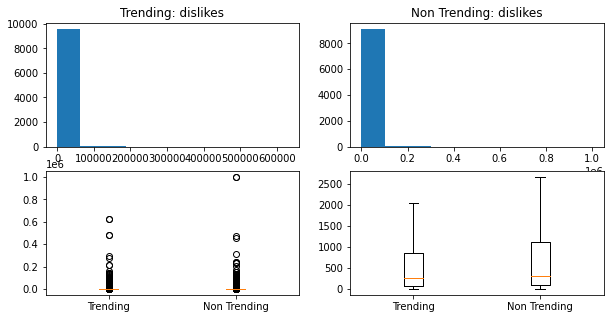

In [44]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

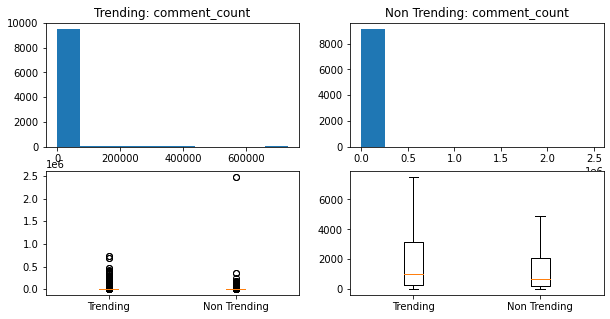

In [45]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

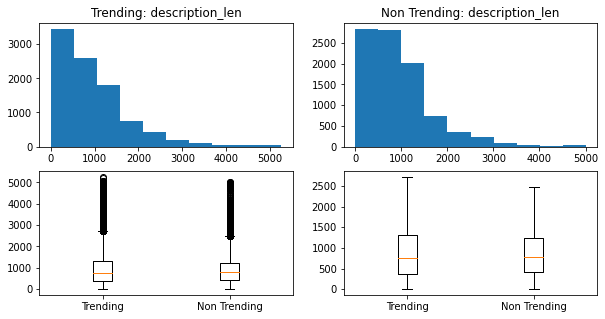

In [46]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

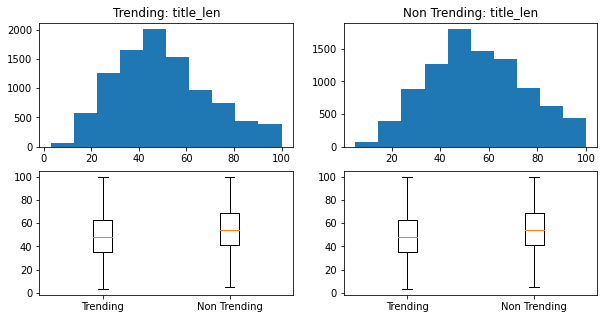

In [47]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

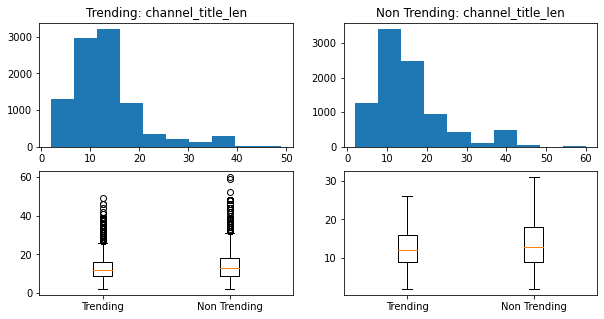

In [48]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)

**Liczba linków**

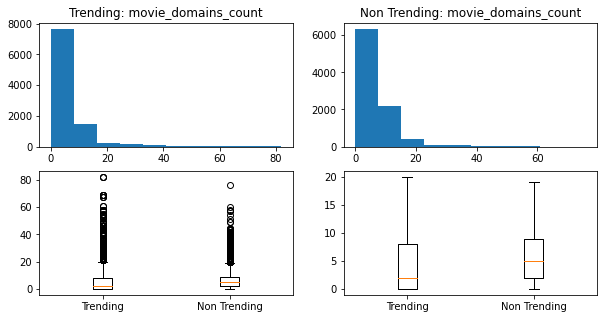

In [49]:
plot_numeric_attr("movie_domains_count", trending_videos, non_trending_videos)

### Atrybuty czasowe

**Dzień opublikowania filmu**

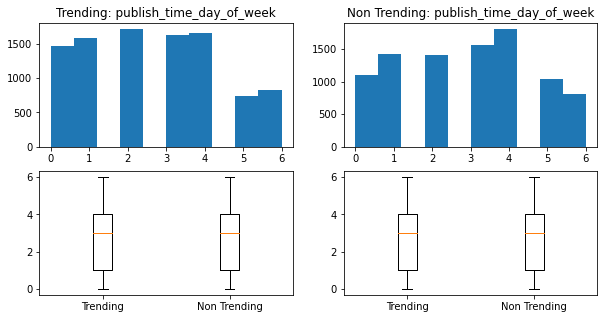

In [50]:
plot_numeric_attr("publish_time_day_of_week", trending_videos, non_trending_videos, )

**Godzina opublikowania filmu**

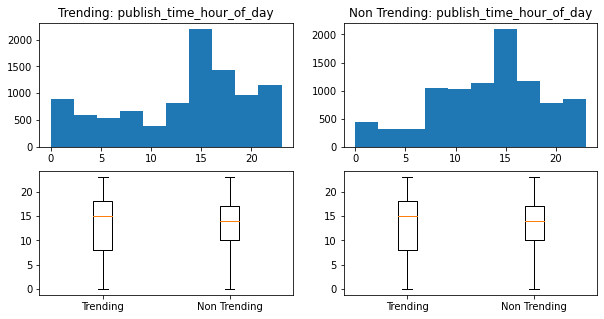

In [51]:
plot_numeric_attr("publish_time_hour_of_day", trending_videos, non_trending_videos)

**Data publikacji**

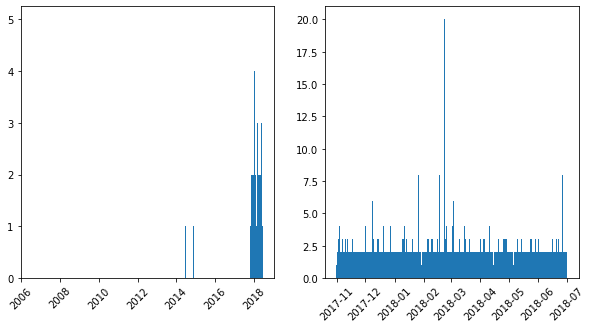

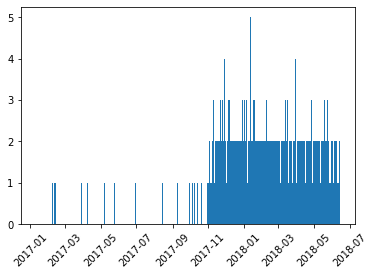

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

trending_publish_time_counts = pd.to_datetime(trending_videos["publish_time"],
                                              format="%Y-%m-%dT%H:%M:%S.%fZ").value_counts()
trending_publish_time_counts = trending_publish_time_counts.rename_axis("publish_time").reset_index(name="count")

publish_times = pd.to_datetime(trending_videos["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ")
filtered = publish_times[publish_times >= "2017-01-01"]
filtered_counts = filtered.value_counts().rename_axis("publish_time").reset_index(name="count")

non_trending_publish_time_counts = pd.to_datetime(non_trending_videos["publish_time"],
                                                  format="%Y-%m-%dT%H:%M:%SZ").value_counts()
non_trending_publish_time_counts = non_trending_publish_time_counts.rename_axis("publish_time").reset_index(
    name="count")

axes[0].bar(pd.to_datetime(trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"),
            trending_publish_time_counts["count"])
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

axes[1].bar(pd.to_datetime(non_trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%SZ"),
            non_trending_publish_time_counts["count"])
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
plt.show()

plt.bar(pd.to_datetime(filtered_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"), filtered_counts["count"])
plt.xticks(rotation=45)
plt.show()

### Atrybuty tekstowe

**Metoda do wyświetlania wykresów**

In [53]:
def plot_tokenized_stats(attr_name):
    us_tokens = load_tokenized_text(f"US_grouped_{attr_name}s")
    gb_tokens = load_tokenized_text(f"GB_grouped_{attr_name}s")
    trending_tokens = []
    trending_words = []
    for i, tokens_list in enumerate(gb_tokens + us_tokens):
        if len(tokens_list) > 0:
            trending_tokens.append(tokens_list[0])
            trending_words += tokens_list[0]
        else:
            trending_tokens.append([])
    trending_words = pd.DataFrame(data={"words": trending_words})
    trending_values_counts = trending_words.value_counts().rename_axis("words").reset_index(name="count")
    tr_head = trending_values_counts.head(50)
    non_trending_path = os.path.join("non_trending", "words")

    gb_non_words = load_csv_file(os.path.join(non_trending_path, f"GB_{attr_name}.csv"))
    us_non_words = load_csv_file(os.path.join(non_trending_path, f"US_{attr_name}.csv"))
    non_trending_words = pd.concat([gb_non_words, us_non_words])
    non_trending_values_counts = non_trending_words.value_counts().rename_axis("words").reset_index(name="count")
    non_tr_head = non_trending_values_counts.head(50)

    plt.subplots(figsize=(18, 5))
    plt.bar(tr_head["words"], tr_head["count"])
    plt.title("Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()


    plt.subplots(figsize=(18, 5))
    plt.bar(non_tr_head["words"], non_tr_head["count"])
    plt.title("Non Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

**Tytuły kanałów - channel_title**

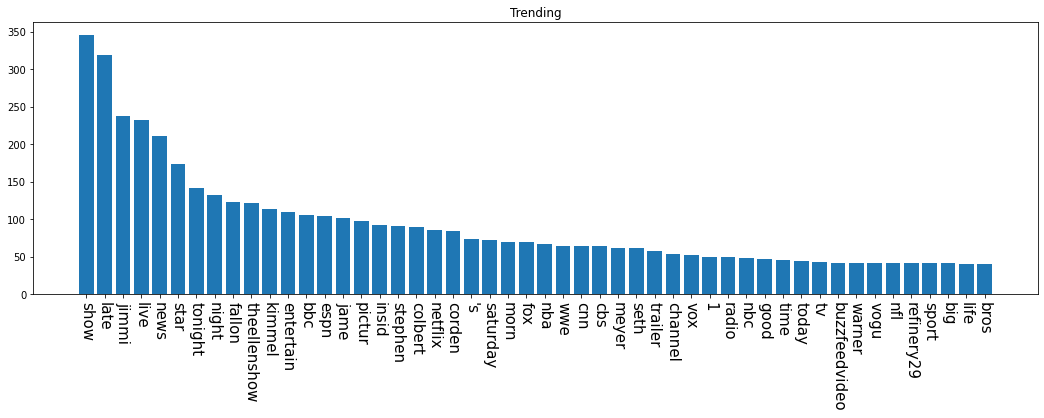

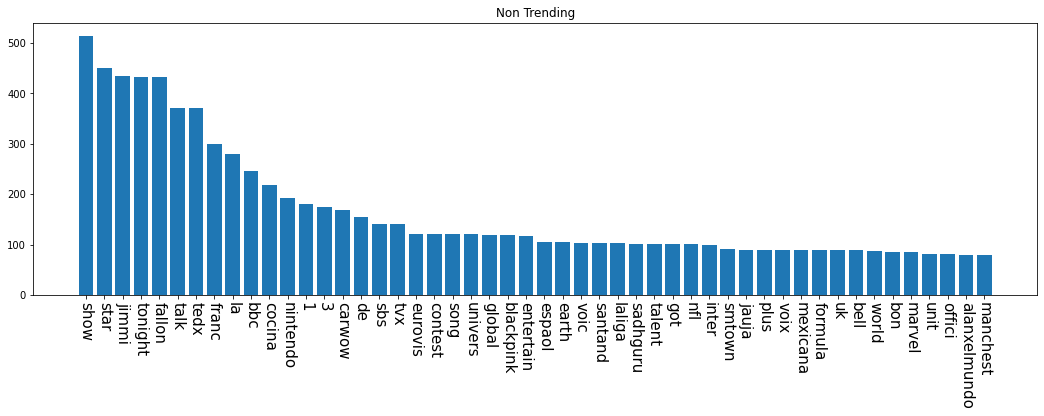

In [54]:
plot_tokenized_stats("channel_title")

**Tytuły filmów - title**

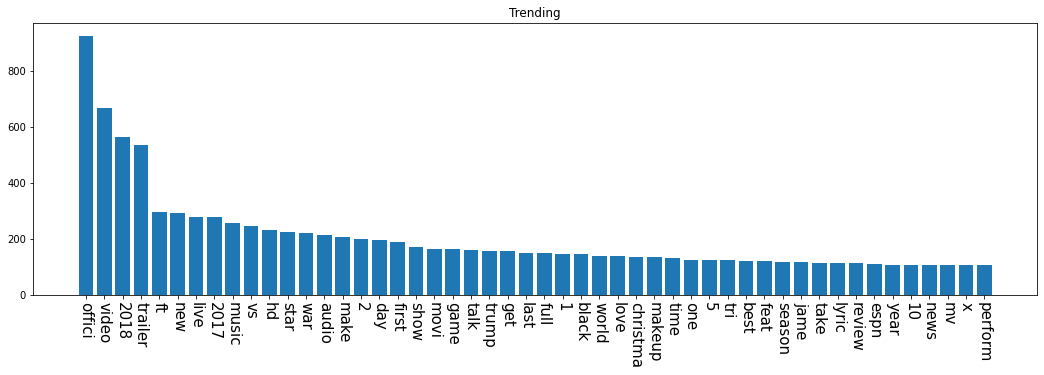

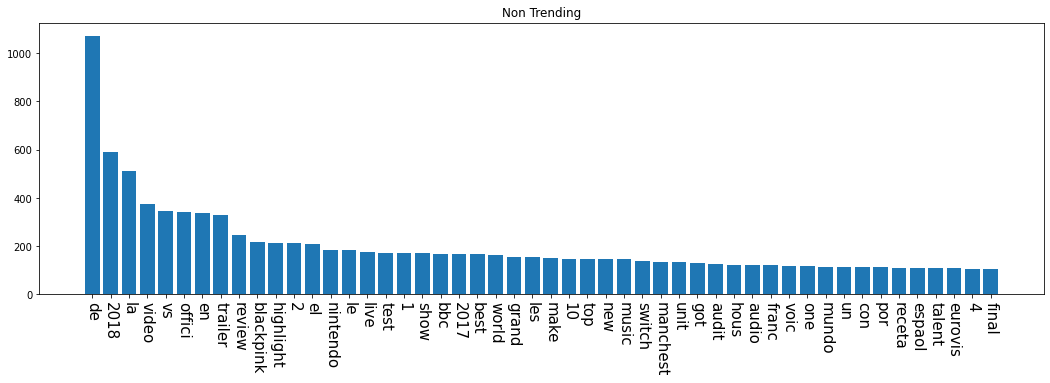

In [55]:
plot_tokenized_stats("title")

**Opisy filmów - description**

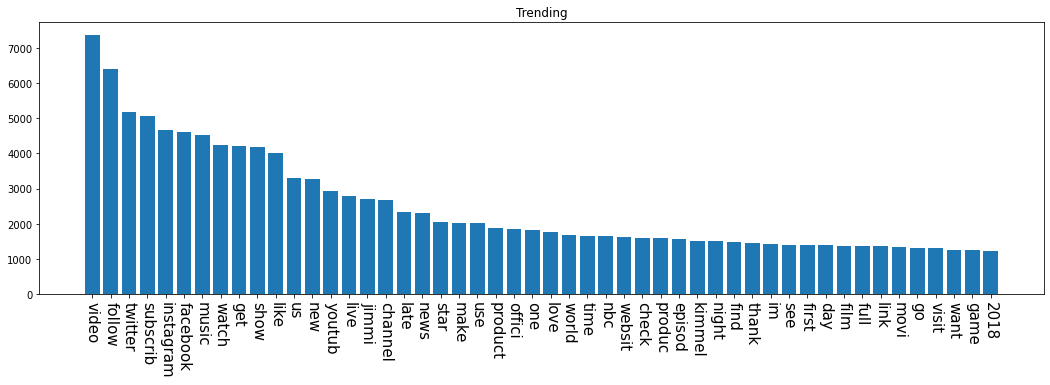

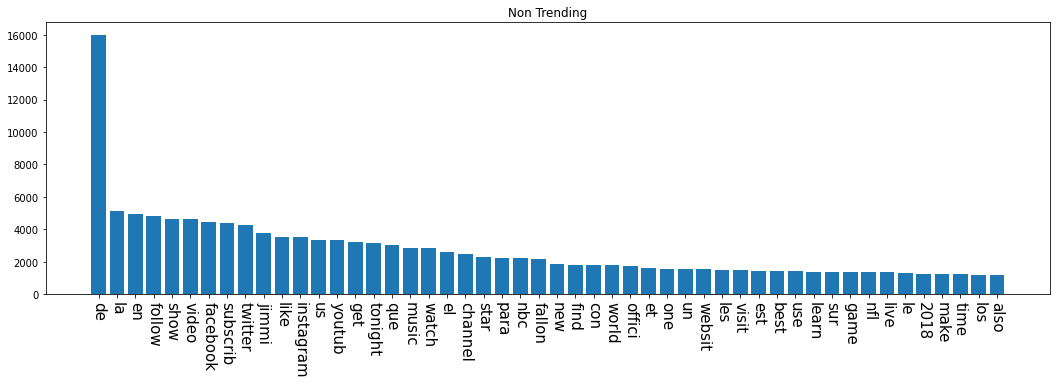

In [56]:
plot_tokenized_stats("description")

**Domeny**

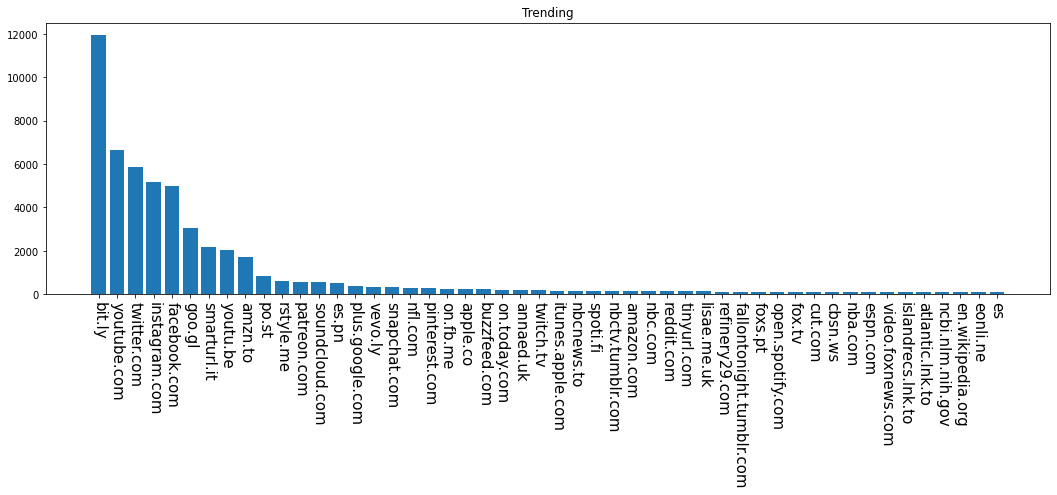

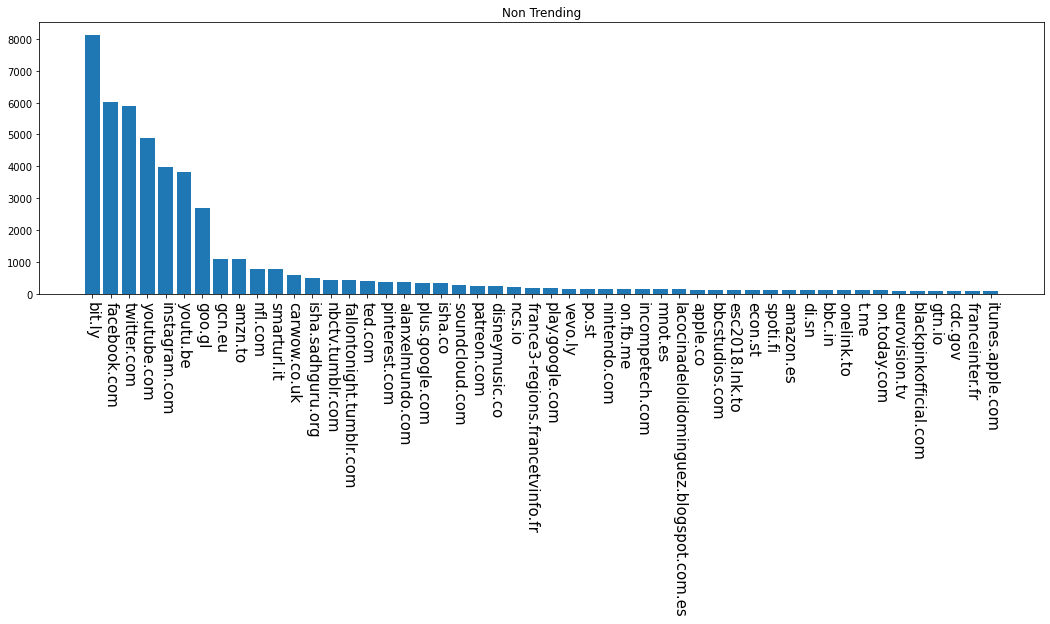

In [57]:
plot_tokenized_stats("domain")


### Ocena atrybutów
